# 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.

## Get Data

In [11]:
import requests
from pathlib import Path
import zipfile
import os

# Datapath and imagepath
data_path = Path('./data')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
  print(f'Folder {image_path} already exist')
else:
  print(f'Creating folder {image_path}')
  image_path.mkdir(parents=True, exist_ok=True)

  # Get url
  url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

  # Download
  with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get(url)
    print('Downloading...')
    f.write(request.content)

  # Unzip
  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as f:
    print('Unzipping')
    f.extractall(image_path)

  # Remove zip file
  os.remove(data_path / 'pizza_steak_sushi.zip')

# Set up train, set directory
train_dir = image_path / "train"
test_dir = image_path / "test"

Folder data/pizza_steak_sushi already exist


## Get functionfrom Github

In [12]:
try:
  from going_modular import data_setup, engine, utils
except:
  !git clone https://github.com/NGQ-Hiro/Basic_Pytorch.git
  !mv Basic_Pytorch/going_modular .
  !rm -rf Basic_Pytorch
  from going_modular import data_setup, engine, utils

## Prepare Data

In [13]:
import torchvision
from torchvision import transforms
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])


# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bdf2c64fe50>,
 ['pizza', 'steak', 'sushi'])

## Get and prepare a pretrained model

In [16]:
import torch

# Set up device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set up pretrained model_0
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all base layer of model_0
for param in model_0.features.parameters():
  param.requires_grad = False

# Set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Change classifier
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
  torch.nn.Linear(in_features=1280,
                  out_features=len(class_names),
                  bias=True)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train model

In [18]:
from inspect import EndOfBlock
# Define Loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

# Set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Set up results
model_0_results = engine.train(model=model_0,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              epochs=5,
                              device=device)

# End timer
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1033 | train_acc: 0.3789 | test_loss: 0.8906 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6445 | test_loss: 0.8079 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7611 | train_acc: 0.8945 | test_loss: 0.6431 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7602 | train_acc: 0.6992 | test_loss: 0.5840 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6309 | train_acc: 0.8867 | test_loss: 0.6012 | test_acc: 0.9072
Total training time: 176.495 seconds


## Make preditions on test_dataloader with the model_0

In [31]:
from tqdm.auto import tqdm
import torch

test_pred = []

# Turn on eval mode
model_0.eval()

# Turn on inference mode
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    # Put data to target device
    X, y = X.to(device), y.to(device)

    # Forward
    y_logits = model_0(X)

    # Predict probability
    y_prob = torch.softmax(y_logits, dim=1)

    # Predict label
    y_pred = torch.argmax(y_prob, dim=1)

    test_pred.append(y_pred)

test_pred = torch.cat(test_pred)
test_pred

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [34]:
test_label = torch.cat([y for x, y in test_dataloader])
test_label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

## Make a confusion matrix with the pred and label

In [36]:
try:
  import torchmetrics, mlxtend
except:
  print("Downloading torchmetric, mlxtend")
  !pip install torchmetrics mlxtend


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 14.2 MB/s eta 0:00:00


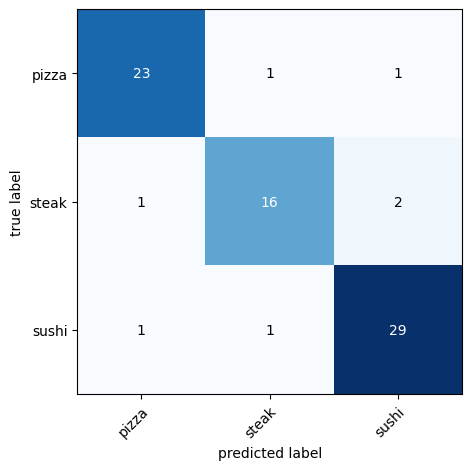

In [45]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
# Setup and calculate confusion matrix
cf = ConfusionMatrix(task='MULTICLASS',num_classes=len(class_names))
cf_result = cf(test_pred, test_label)

# Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cf_result.numpy(),
                                class_names=class_names,
                                figsize=(5, 5)
                                )

# 2. Get most wrong of the predictions on the test dataset

In [53]:
from pathlib import Path
test_data_path = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_path]

def pred_and_store(test_paths: str,
                   model: torch.nn.Module,
                   transform: transforms,
                   class_names,
                   device: torch.device = device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict
    pred_dict = {}

    # Get path
    pred_dict["image_path"] = path

    # Get class name
    pred_dict["class_name"] = path.parent.stem

    # Open and transform image
    from PIL import Image
    image = Image.open(path)
    image_transformed = transform(image).unsqueeze(dim=0)

    # Eval mode
    model.eval()

    # Turn on inference mode
    with torch.inference_mode():
      y_logits = model(image_transformed.to(device))
      y_prob = torch.softmax(y_logits, dim=1)
      y_pred = torch.argmax(y_prob, dim=1)

      pred_dict["pred_class"] = class_names[y_pred]
      pred_dict["pred_prob"] = y_prob.max().item()

      pred_dict["correct"] = (pred_dict["pred_class"] == pred_dict["class_name"])

      test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_list = pred_and_store(test_data_path, model_0, simple_transform, class_names)
test_pred_list[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
  'class_name': 'steak',
  'pred_class': 'sushi',
  'pred_prob': 0.388567715883255,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.49255669116973877,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.6630023717880249,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.679990291595459,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.6454727649688721,
  'correct': True}]

In [59]:
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_list)
test_pred_df.sort_values(by=['pred_prob', 'correct'], ascending=[True, True]).head()

,image_path,class_name,pred_class,pred_prob,correct
8,data/pizza_steak_sushi/test/steak/3873283.jpg,steak,pizza,0.364794,False
65,data/pizza_steak_sushi/test/pizza/2871261.jpg,pizza,sushi,0.366920,False
0,data/pizza_steak_sushi/test/steak/1627703.jpg,steak,sushi,0.388568,False
24,data/pizza_steak_sushi/test/sushi/175783.jpg,sushi,pizza,0.390239,False
31,data/pizza_steak_sushi/test/sushi/2276986.jpg,sushi,sushi,0.397413,True


## Plot curve loss

In [68]:
try:
  from helper_function import plot_loss_curves
except:
  print("Downloading helper_funtion")
  with open("helper_function.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/NGQ-Hiro/Basic_Pytorch/master/helper_function.py")
    f.write(request.content)
  from helper_function import plot_loss_curves

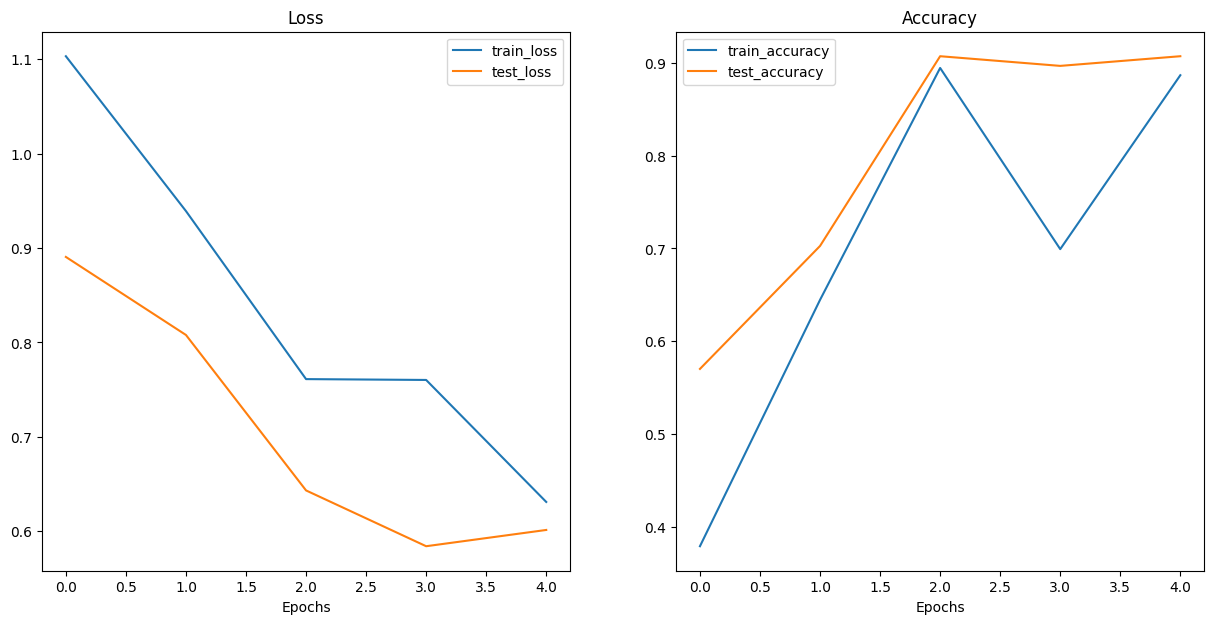

In [69]:
plot_loss_curves(model_0_results)